In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


# On charge les données dans un dataframe "df"
df = pd.read_csv('terrorisme_sahel.csv')


############################################################
## FILTRES SUR LES COLONNES

# On récupère ici seulement les évènements qui nous intéressent, ceux liés à des violences politiques
events_filter = ['Battles', 'Explosions/Remote violence', 'Violence against civilians', 'Strategic developments']
df = df[df['event_type'].isin(events_filter)]

# On réinitialise l'index
df = df.reset_index(drop=True)


############################################################
## TRANSFORMATION DES COLONNES

# On transforme la colonne "event_date" en datetime pour la manipuler plus facilement
df['event_date'] = pd.to_datetime(df['event_date'])


############################################################
## CREATION DE NOUVELLES COLONNES

# On crée la colonne "month" en utilisant l'attribut month de datetime
df['month'] = df['event_date'].dt.month
# On ajoute la colonne juste après "year"
df.insert(3, 'month', df.pop('month'))


##
# On ajoute des colonnes "actor1_type" et "actor2 _type"qui permettent d'avoir le nom de la catégorie d'acteur

# Ce dictionnaire associe les valeurs des colonnes "inter1" et "inter2"
# au nom de chaque catégorie d'acteur (source : codebook ACLED)
actor_type = {
    1: "State Forces",
    2: "Rebel Groups",
    3: "Political Militias",
    4: "Identity Militias",
    5: "Rioters",
    6: "Protesters",
    7: "Civilians",
    8: "External/Other Forces",
}

# On ajoute les colonnes "actor1_type" et "actor2_type" au dataframe
df['actor1_type'] = df['inter1'].map(actor_type)
df['actor2_type'] = df['inter2'].map(actor_type)


##
# On ajoute une colonne "interaction_type" qui permet d'avoir le nom du type d'interaction entre 2 acteurs

# On crée un dictionnaire associant aux valeurs de la colonne "interaction"
# les 2 acteurs impliqués dans une confrontation (source : codebook ACLED)
interaction_type = {
    10: 'SOLE STATE FORCES ACTION',
    11: 'STATE FORCES VERSUS STATE FORCES',
    12: 'STATE FORCES VERSUS REBELS',
    13: 'STATE FORCES VERSUS POLITICAL MILITIA',
    14: 'STATE FORCES VERSUS IDENTITY MILITIA',
    15: 'STATE FORCES VERSUS RIOTERS',
    16: 'STATE FORCES VERSUS PROTESTERS',
    17: 'STATE FORCES VERSUS CIVILIANS',
    18: 'STATE FORCES VERSUS EXTERNAL/OTHER FORCES',
    20: 'SOLE REBEL ACTION',
    22: 'REBELS VERSUS REBELS',
    23: 'REBELS VERSUS POLITICAL MILITIA',
    24: 'REBELS VERSUS IDENTITY MILITIA',
    25: 'REBELS VERSUS RIOTERS',
    26: 'REBELS VERSUS PROTESTERS',
    27: 'REBELS VERSUS CIVILIANS',
    28: 'REBELS VERSUS OTHERS',
    30: 'SOLE POLITICAL MILITIA ACTION',
    33: 'POLITICAL MILITIA VERSUS POLITICAL MILITIA',
    34: 'POLITICAL MILITIA VERSUS IDENTITY MILITIA',
    35: 'POLITICAL MILITIA VERSUS RIOTERS',
    36: 'POLITICAL MILITIA VERSUS PROTESTERS',
    37: 'POLITICAL MILITIA VERSUS CIVILIANS',
    38: 'POLITICAL MILITIA VERSUS OTHERS',
    40: 'SOLE IDENTITY MILITIA ACTION',
    44: 'IDENTITY MILITIA VERSUS IDENTITY MILITIA',
    45: 'IDENTITY MILITIA VERSUS RIOTERS',
    46: 'IDENTITY MILITIA VERSUS PROTESTERS',
    47: 'IDENTITY MILITIA VERSUS CIVILIANS',
    48: 'IDENTITY MILITIA VERSUS OTHER',
    50: 'SOLE RIOTER ACTION',
    55: 'RIOTERS VERSUS RIOTERS',
    56: 'RIOTERS VERSUS PROTESTERS',
    57: 'RIOTERS VERSUS CIVILIANS',
    58: 'RIOTERS VERSUS OTHERS',
    60: 'SOLE PROTESTER ACTION',
    66: 'PROTESTERS VERSUS PROTESTERS',
    67: 'PROTESTERS VERSUS CIVILIANS',
    68: 'PROTESTERS VERSUS OTHER',
    70: 'SOLE CIVILIAN ACTION',
    77: 'CIVILIANS VERSUS CIVILIANS',
    78: 'OTHER ACTOR VERSUS CIVILIANS',
    80: 'SOLE OTHER ACTION',
    88: 'OTHER VERSUS OTHER'
}

# On ajoute une colonne "interaction_type" au dataframe
df['interaction_type'] = df['interaction'].map(interaction_type)


##
# On crée une nouvelle colonne qui indique si pour un évènement l'un des acteurs est une organisation terroriste

# On crée une liste contenant les organisations terroristes
terrorist_groups = ['Ansaroul Islam',
                       'AQIM: Al Qaeda in the Islamic Maghreb',
                       'Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'Islamic State (Sahel)',
                       'Islamic State (West Africa)',
                       'Islamic State (West Africa) - Lake Chad Faction',
                       'Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'JNIM: Group for Support of Islam and Muslims',
                       'JNIM: Group for Support of Islam and Muslims and/or Islamic State (Sahel)',
                       'Katiba Gourma',
                       'Katiba Macina',
                       'Katiba Serma']

# On crée une fonction pour vérifier si un acteur est une organisation terroriste
def is_terrorist_actor(actor):
    return actor in terrorist_groups

# On ajoute la colonne "is_terrorist_group_related" au dataframe
df['is_terrorist_group_related'] = (df['actor1'].apply(is_terrorist_actor) |
                             df['assoc_actor_1'].apply(is_terrorist_actor) |
                             df['actor2'].apply(is_terrorist_actor) |
                             df['assoc_actor_2'].apply(is_terrorist_actor)).astype(int)


##
# On crée une nouvelle colonne qui indique si pour un évènement l'un des acteurs est une pmc russe
pmc_groups = ['Wagner Group']

# On crée une fonction pour vérifier si un acteur est une pmc russe
def is_pmc_actor(actor):
    return actor in pmc_groups

# On ajoute la colonne "is_pmc_related" au dataframe
df['is_pmc_related'] = (df['actor1'].apply(is_pmc_actor) |
                             df['assoc_actor_1'].apply(is_pmc_actor) |
                             df['actor2'].apply(is_pmc_actor) |
                             df['assoc_actor_2'].apply(is_pmc_actor)).astype(int)


##
# On crée une nouvelle colonne 'terrorist_group_filiation' qui permet d'associer chaque organisation terroriste
# à son organisation mère

# On crée d'abord un dictionnaire d'association entre organisation terroriste et organisation mère
terrorist_group_filiation = {
    'Ansaroul Islam': 'Al Qaida',
    'AQIM: Al Qaeda in the Islamic Maghreb': 'Al Qaida',
    'Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
    'Islamic State (Sahel)' : 'Etat Islamique',
    'Islamic State (West Africa)': 'Etat Islamique',
    'Islamic State (West Africa) - Lake Chad Faction': 'Etat Islamique',
    'Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
    'Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
    'JNIM: Group for Support of Islam and Muslims': 'Al Qaida',
    'JNIM: Group for Support of Islam and Muslims and/or Islamic State (Sahel)': 'Al Qaida',
    'Katiba Gourma': 'Al Qaida',
    'Katiba Macina': 'Al Qaida',
    'Katiba Serma': 'Al Qaida'
}

# On crée une fonction de mapping pour associer les valeurs du dictionnaire aux acteurs
def map_filiation(row):
    for actor in ['actor1', 'assoc_actor_1', 'actor2', 'assoc_actor_2']:
        if row[actor] in terrorist_group_filiation:
            return terrorist_group_filiation[row[actor]]
    return "Aucune"

# On ajoute la colonne "terrorist_group_filiation" au dataframe
df['terrorist_group_filiation'] = df.apply(map_filiation, axis=1)


############################################################
## SUPPRESSION DES COLONNES

# On supprime les colonnes qui ne nous serons d'aucune utilité
columns_to_drop = [
    'time_precision',
    'disorder_type',
    'sub_event_type',
    'actor1',
    'assoc_actor_1',
    'actor1_type',
    'actor2',
    'assoc_actor_2',
    'actor2_type',
    'interaction_type',
    'inter1',
    'inter2',
    'interaction',
    'admin2',
    'admin3',
    'iso',
    'region',
    'location',
    'latitude',
    'longitude',
    'geo_precision',
    'source',
    'source_scale',
    'notes',
    'tags',
    'timestamp',
    'civilian_targeting',
    'event_id_cnty'
]

In [2]:
# On supprime les colonnes spécifiées dans la liste 'columns_to_drop' du dataframe
df = df.drop(columns=columns_to_drop, axis=1)

# On dichotomise la variable 'event_type' qui est de type catégorielle
# et qui sera très importante pour la suite de notre étude
# Cela crée des colonnes binaires pour chaque type d'événement, facilitant l'analyse.
df = pd.get_dummies(df, columns=['event_type'], dtype=int)


# On dichotomise la variable 'terrorist_org_afiliation' qui nous permet de filtrer
# sur chaque afiliation d'un groupe terroriste
# Cela crée des colonnes binaires pour chaque affiliation de groupe terroriste.
df = pd.get_dummies(df, columns=['terrorist_group_filiation'], dtype=int)

# On supprime la colonne 'terrorist_group_filiation_Aucune' car elle n'apporte pas d'information utile.
df = df.drop(columns=['terrorist_group_filiation_Aucune'], axis=1)

In [3]:
# Affiche toutes les colonnes du dataframe
df.columns

Index(['event_date', 'year', 'month', 'country', 'admin1', 'fatalities',
       'is_terrorist_group_related', 'is_pmc_related', 'event_type_Battles',
       'event_type_Explosions/Remote violence',
       'event_type_Strategic developments',
       'event_type_Violence against civilians',
       'terrorist_group_filiation_Al Qaida',
       'terrorist_group_filiation_Etat Islamique'],
      dtype='object')

In [4]:
# Affiche la forme du dataframe, c'est-à-dire le nombre de lignes et de colonnes
df.shape


(14054, 14)

In [5]:
# Trie les lignes du dataframe en fonction de la colonne 'event_date'
df = df.sort_values(by='event_date')


In [6]:
# Crée un nouveau dataframe contenant uniquement les colonnes spécifiées
df_2 = df[['event_date', 'year', 'month', 'country', 'admin1', 'is_terrorist_group_related']]

df_2 = df_2[df_2['is_terrorist_group_related'] == 1]

# Filtre les données pour ne garder que les événements au Mali
df_2_mali = df_2[df_2['country'] == 'Mali']
df_2_mali

# Regroupe les données du Mali par année, mois et admin1, puis compte le nombre d'événements pour chaque groupe
df_2_mali_by_month_original = df_2_mali.groupby(['year', 'month', 'admin1']).size()

In [7]:
# Réinitialise l'index du dataframe regroupé et nomme la colonne des comptages 'nb_events_by_admin'
df_2_mali_by_month_original = df_2_mali_by_month_original.reset_index(name = 'nb_events_by_admin')
df_2_mali_by_month_original

,year,month,admin1,nb_events_by_admin
0,2021,6,Gao,7
1,2021,6,Kidal,3
2,2021,6,Koulikoro,1
3,2021,6,Menaka,1
4,2021,6,Mopti,34
...,...,...,...,...
291,2024,4,Koulikoro,6
292,2024,4,Menaka,9
293,2024,4,Mopti,32
294,2024,4,Segou,20


In [8]:
df_2_mali_by_month_original[(df_2_mali_by_month_original['admin1'] == 'Gao' ) & (df_2_mali_by_month_original['month'] == 10)]['nb_events_by_admin']


32      4
133    32
235    13
Name: nb_events_by_admin, dtype: int64

In [9]:
# nombre de mois qu'on ajoute en variables explicatives de chaque mois :
# Pour un mois t on ajoute nb_events_by_admin_M-m pour m allant de 1 à nb_months_before
nb_months_before = 6

# Boucle sur les mois précédents à inclure comme variables explicatives
for m in range(1, nb_months_before+1): # pour chaque mois de 1 à 7 exclu
    # Itère sur chaque ligne du dataframe
    for i, r in df_2_mali_by_month_original.iterrows(): # i est l'index de la ligne et r la ligne en question; iterrows() 
        
        #Je récupère les valeurs de la colo nb_events_by_admin pour le partie du dataframe où les conditions sont vraies
        if (r.month -m <= 0 ): 
            previous_value = df_2_mali_by_month_original[
                (df_2_mali_by_month_original['year'] == r.year -1) &
                (df_2_mali_by_month_original['month'] == (r.month - m + 12)) & 
                (df_2_mali_by_month_original['admin1'] == r.admin1)
            ]['nb_events_by_admin'].values
            
        #parcourt le dataframe une ligne à la fois
        # Récupère la valeur du nombre d'événements pour le mois précédent (M-m)
        else:
            previous_value = df_2_mali_by_month_original[
                (df_2_mali_by_month_original['year'] == r.year) &
                (df_2_mali_by_month_original['month'] == (r.month - m)) & 
                (df_2_mali_by_month_original['admin1'] == r.admin1)
            ]['nb_events_by_admin'].values

        # Ajoute la valeur précédente comme nouvelle colonne, ou 0 si elle n'existe pas
        df_2_mali_by_month_original.loc[
            (df_2_mali_by_month_original['year'] == r.year) &
            (df_2_mali_by_month_original['month'] == r.month) &
            (df_2_mali_by_month_original['admin1'] == r.admin1),
            'nb_events_by_admin_M-'+str(m)] = 0 if len(previous_value) == 0 else previous_value[0]


In [10]:
df_2_mali_by_month_original

,year,month,admin1,nb_events_by_admin,nb_events_by_admin_M-1,nb_events_by_admin_M-2,nb_events_by_admin_M-3,nb_events_by_admin_M-4,nb_events_by_admin_M-5,nb_events_by_admin_M-6
0,2021,6,Gao,7,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,6,Kidal,3,0.0,0.0,0.0,0.0,0.0,0.0
2,2021,6,Koulikoro,1,0.0,0.0,0.0,0.0,0.0,0.0
3,2021,6,Menaka,1,0.0,0.0,0.0,0.0,0.0,0.0
4,2021,6,Mopti,34,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
291,2024,4,Koulikoro,6,9.0,7.0,3.0,10.0,2.0,3.0
292,2024,4,Menaka,9,8.0,7.0,10.0,6.0,2.0,8.0
293,2024,4,Mopti,32,39.0,45.0,35.0,33.0,37.0,33.0
294,2024,4,Segou,20,26.0,27.0,27.0,28.0,31.0,34.0


In [11]:
# Transformation de la colonne 'admin1' en variables dichotomiques (one-hot encoding)
df_2_mali_by_month = pd.get_dummies(df_2_mali_by_month_original, columns=['admin1'], dtype=int)

# Affichage du dataframe résultant
df_2_mali_by_month



,year,month,nb_events_by_admin,nb_events_by_admin_M-1,nb_events_by_admin_M-2,nb_events_by_admin_M-3,nb_events_by_admin_M-4,nb_events_by_admin_M-5,nb_events_by_admin_M-6,admin1_Bamako,admin1_Gao,admin1_Kayes,admin1_Kidal,admin1_Koulikoro,admin1_Menaka,admin1_Mopti,admin1_Segou,admin1_Sikasso,admin1_Tombouctou
0,2021,6,7,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0
1,2021,6,3,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0
2,2021,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0
3,2021,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0
4,2021,6,34,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,2024,4,6,9.0,7.0,3.0,10.0,2.0,3.0,0,0,0,0,1,0,0,0,0,0
292,2024,4,9,8.0,7.0,10.0,6.0,2.0,8.0,0,0,0,0,0,1,0,0,0,0
293,2024,4,32,39.0,45.0,35.0,33.0,37.0,33.0,0,0,0,0,0,0,1,0,0,0
294,2024,4,20,26.0,27.0,27.0,28.0,31.0,34.0,0,0,0,0,0,0,0,1,0,0


In [12]:
df_2_mali_by_month_mopti = df_2_mali_by_month[df_2_mali_by_month['admin1_Mopti'] == 1]
df_2_mali_by_month_mopti

,year,month,nb_events_by_admin,nb_events_by_admin_M-1,nb_events_by_admin_M-2,nb_events_by_admin_M-3,nb_events_by_admin_M-4,nb_events_by_admin_M-5,nb_events_by_admin_M-6,admin1_Bamako,admin1_Gao,admin1_Kayes,admin1_Kidal,admin1_Koulikoro,admin1_Menaka,admin1_Mopti,admin1_Segou,admin1_Sikasso,admin1_Tombouctou
4,2021,6,34,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
12,2021,7,58,34.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
20,2021,8,41,58.0,34.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
28,2021,9,22,41.0,58.0,34.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
36,2021,10,25,22.0,41.0,58.0,34.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
44,2021,11,23,25.0,22.0,41.0,58.0,34.0,0.0,0,0,0,0,0,0,1,0,0,0
53,2021,12,29,23.0,25.0,22.0,41.0,58.0,34.0,0,0,0,0,0,0,1,0,0,0
61,2022,1,43,29.0,23.0,25.0,22.0,41.0,58.0,0,0,0,0,0,0,1,0,0,0
69,2022,2,34,43.0,29.0,23.0,25.0,22.0,41.0,0,0,0,0,0,0,1,0,0,0
78,2022,3,32,34.0,43.0,29.0,23.0,25.0,22.0,0,0,0,0,0,0,1,0,0,0


In [13]:
# Séparation des données en variables explicatives (features) et variable cible (target)
data = df_2_mali_by_month.drop('nb_events_by_admin', axis = 1)

# On retire la colonne 'nb_events_by_admin' des données pour la placer dans la variable cible
target = df_2_mali_by_month['nb_events_by_admin']

In [14]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state = 12, shuffle = False)

In [15]:
print(X_train)

     year  month  nb_events_by_admin_M-1  nb_events_by_admin_M-2  \
0    2021      6                     0.0                     0.0   
1    2021      6                     0.0                     0.0   
2    2021      6                     0.0                     0.0   
3    2021      6                     0.0                     0.0   
4    2021      6                     0.0                     0.0   
..    ...    ...                     ...                     ...   
231  2023      9                    34.0                    49.0   
232  2023      9                    11.0                    18.0   
233  2023      9                     0.0                     3.0   
234  2023      9                    23.0                     8.0   
235  2023     10                    16.0                    12.0   

     nb_events_by_admin_M-3  nb_events_by_admin_M-4  nb_events_by_admin_M-5  \
0                       0.0                     0.0                     0.0   
1                       0

In [16]:
print(X_test)

     year  month  nb_events_by_admin_M-1  nb_events_by_admin_M-2  \
236  2023     10                     0.0                     0.0   
237  2023     10                     1.0                     0.0   
238  2023     10                     4.0                     4.0   
239  2023     10                     4.0                     9.0   
240  2023     10                    24.0                    34.0   
241  2023     10                    29.0                    11.0   
242  2023     10                     1.0                     0.0   
243  2023     10                    12.0                    23.0   
244  2023     11                    13.0                    16.0   
245  2023     11                    12.0                     1.0   
246  2023     11                     3.0                     4.0   
247  2023     11                     8.0                     4.0   
248  2023     11                    33.0                    24.0   
249  2023     11                    34.0        

In [17]:
# Création et entraînement du modèle RandomForestRegressor
model = RandomForestRegressor(n_estimators=1000, max_depth=15)
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Affichage du score du modèle sur l'ensemble de test
print("RandomForest:", model.score(X_test, y_test))

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calcul de l'erreur absolue moyenne (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)
# Il prédit en moyenne 6.5 événements en plus ou en moins par rapport aux valeurs réelles

# Calcul de l'erreur absolue moyenne en pourcentage (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)


RandomForest: 0.816521385671969
MSE: 26.232345220732668
MAE: 4.224694387752825
MAPE: 0.9721553804274975


In [18]:
model_xgb = XGBRegressor(n_estimators = 1000, max_depth=15)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
print("XGB Score:", model_xgb.score(X_test, y_test))

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)
#Il prédit en moyenne 6.84 évènements de plus ou de moins que les valeurs réelles

#On calcule et affiche la moyenne des erreurs absolues en pourcentage, qui mesure l'erreur moyenne en pourcentage par 
#rapport aux valeurs réelles. Cette mesure est utile pour évaluer la précision du modèle en termes relatifs.
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

XGB Score: 0.6940028691411744
MSE: 43.749089792510446
MAE: 5.304118426640828
MAPE: 1.0917674051149797


In [19]:
#mape est la moyenne des erreurs absolues divisée par y
#commence à créer le dataframe de prédiction

In [33]:
# Entrainement sur tout X
model.fit(data, target)
model_xgb.fit(data, target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
#J prends un datadrame qui a la forme qu'il faut
# On choisit juin 2022 pour avoir un dataset d'un mois où on a toutes les zones administratives
# Ce dataset sert de patron pour initialiser les mois suivants (de mai à octobre 2024)
next_months = pd.DataFrame(
    [df_2_mali_by_month_original.iloc[0]]
    *df_2_mali_by_month_original['admin1'].nunique())

next_months['admin1'] = df_2_mali_by_month_original['admin1'].unique()

#Je mets la ligne du premier mois
# Initialiser le mois et l'année pour commencer les prédictions à partir de mai 2024
# On duplique ce mois de mai à octobre en mettant les bonnes valuers de mois et année
month_start, month_end = 5, 11
next_months['month'] = month_start
next_months['year'] = 2024
next_months['nb_events_by_admin'] = None

In [35]:
next_months

,year,month,admin1,nb_events_by_admin,nb_events_by_admin_M-1,nb_events_by_admin_M-2,nb_events_by_admin_M-3,nb_events_by_admin_M-4,nb_events_by_admin_M-5,nb_events_by_admin_M-6
0,2024,5,Gao,None,0.0,0.0,0.0,0.0,0.0,0.0
0,2024,5,Kidal,None,0.0,0.0,0.0,0.0,0.0,0.0
0,2024,5,Koulikoro,None,0.0,0.0,0.0,0.0,0.0,0.0
0,2024,5,Menaka,None,0.0,0.0,0.0,0.0,0.0,0.0
0,2024,5,Mopti,None,0.0,0.0,0.0,0.0,0.0,0.0
0,2024,5,Segou,None,0.0,0.0,0.0,0.0,0.0,0.0
0,2024,5,Sikasso,None,0.0,0.0,0.0,0.0,0.0,0.0
0,2024,5,Tombouctou,None,0.0,0.0,0.0,0.0,0.0,0.0
0,2024,5,Kayes,None,0.0,0.0,0.0,0.0,0.0,0.0
0,2024,5,Bamako,None,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# All_next_months va contenir les 6 mois avant avril 2024 (inclus) et les 6 mois après
# les six mois avant sont nécessaires pour faire la prédiction des mois après
all_next_months = pd.concat(
    [
        df_2_mali_by_month_original[
            ((df_2_mali_by_month_original['year'] == 2024) & df_2_mali_by_month_original['month'].isin(range(1, 5))) |
            ((df_2_mali_by_month_original['year'] == 2023) & df_2_mali_by_month_original['month'].isin(range(11, 13)))
        ]
    ])


In [37]:
#all_month ne contient qu'un seul mois pour toute =s les régions
print(all_next_months)

     year  month      admin1  nb_events_by_admin  nb_events_by_admin_M-1  \
244  2023     11         Gao                   9                    13.0   
245  2023     11       Kidal                  11                    12.0   
246  2023     11   Koulikoro                   2                     3.0   
247  2023     11      Menaka                   2                     8.0   
248  2023     11       Mopti                  37                    33.0   
249  2023     11       Segou                  31                    34.0   
250  2023     11     Sikasso                   2                     2.0   
251  2023     11  Tombouctou                   9                    12.0   
252  2023     12         Gao                  18                     9.0   
253  2023     12       Kayes                   1                     0.0   
254  2023     12       Kidal                  13                    11.0   
255  2023     12   Koulikoro                  10                     2.0   
256  2023   

In [38]:
# On rajoute un nouveau mois à chaque fois de mai à octobre
# et on met None dans la colonne target (nb_events_by_admin)
for m in range(month_start, month_end):
    
    # Copier le dataframe de référence
    current_month = next_months.copy()
    
    # Initialiser la colonne 'nb_events_by_admin' à None (ou NaN)
    current_month['nb_events_by_admin'] = None
    
    # Mettre à jour le mois
    current_month['month'] = m
    
    # Ajouter le mois courant au dataframe 'all_next_months'
    all_next_months = pd.concat([all_next_months, current_month])

In [39]:
# On ajoute les nb_events des mois précedents pour faire les prédictions des mois suivants (changement des variables explicatives)

# Boucle sur les mois précédents pour ajouter les colonnes correspondantes

for m in range(1, nb_months_before):
    for i, r in all_next_months.iterrows():
        
        if (r.month - m) <= 0:
            previous_value = all_next_months[
                (all_next_months['year'] == r.year - 1) &
                (all_next_months['month'] == (r.month - m) +12) & 
                (all_next_months['admin1'] == r.admin1)
            ]['nb_events_by_admin'].values

        else:
            # Récupérer la valeur du nombre d'événements pour le mois précédent (M-m)
            previous_value = all_next_months[
                (all_next_months['year'] == r.year) &
                (all_next_months['month'] == (r.month - m)) & 
                (all_next_months['admin1'] == r.admin1)
            ]['nb_events_by_admin'].values
        
        # Ajouter la valeur précédente comme nouvelle colonne, ou 0 si elle n'existe pas
        all_next_months.loc[
            (all_next_months['year'] == r.year) &
            (all_next_months['month'] == r.month) &
            (all_next_months['admin1'] == r.admin1),
            'nb_events_by_admin_M-'+str(m)] = 0 if len(previous_value) == 0 else previous_value[0]

In [40]:
# <TODO> Enlever le fillna 0 pour prendre en compte les predictions précédentes
#FOn fait la prédiction sur les mois à prédire (c'est à dire les mois où nb_events_by_admin est None)

# Préparation des données pour les prédictions des mois futurs
# Filtrer les lignes où 'nb_events_by_admin' est nul, puis supprimer cette colonne
# Remplir les valeurs manquantes avec 0 et appliquer le one-hot encoding sur 'admin1'
#Les mois à prédire sont tous les mois où j'ai la target 'nb_events_by_admin' à nopne.
next_months_for_predict = pd.get_dummies(
    all_next_months[all_next_months['nb_events_by_admin'].isnull()].drop('nb_events_by_admin', axis=1).fillna(0),
    columns=['admin1'], dtype=int
)

In [41]:
next_months_for_predict[next_months_for_predict['month'] == 5]

,year,month,nb_events_by_admin_M-1,nb_events_by_admin_M-2,nb_events_by_admin_M-3,nb_events_by_admin_M-4,nb_events_by_admin_M-5,nb_events_by_admin_M-6,admin1_Bamako,admin1_Gao,admin1_Kayes,admin1_Kidal,admin1_Koulikoro,admin1_Menaka,admin1_Mopti,admin1_Segou,admin1_Sikasso,admin1_Tombouctou
0,2024,5,29.0,21.0,11.0,18.0,18.0,0.0,0,1,0,0,0,0,0,0,0,0
0,2024,5,2.0,3.0,5.0,3.0,13.0,0.0,0,0,0,1,0,0,0,0,0,0
0,2024,5,6.0,9.0,7.0,3.0,10.0,0.0,0,0,0,0,1,0,0,0,0,0
0,2024,5,9.0,8.0,7.0,10.0,6.0,0.0,0,0,0,0,0,1,0,0,0,0
0,2024,5,32.0,39.0,45.0,35.0,33.0,0.0,0,0,0,0,0,0,1,0,0,0
0,2024,5,20.0,26.0,27.0,27.0,28.0,0.0,0,0,0,0,0,0,0,1,0,0
0,2024,5,0.0,8.0,6.0,1.0,1.0,0.0,0,0,0,0,0,0,0,0,1,0
0,2024,5,9.0,6.0,1.0,17.0,10.0,0.0,0,0,0,0,0,0,0,0,0,1
0,2024,5,1.0,3.0,7.0,1.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0
0,2024,5,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0


In [42]:
for m in range(month_start, month_end):
    next_month_for_predict = next_months_for_predict[next_months_for_predict['month'] == m]
    print(m, next_month_for_predict.shape)
    # Utiliser le modèle pour prédire le nombre d'événements pour chaque mois futur
    y_pred_next_month = model.predict(next_month_for_predict)

    #Avant target, j'avais mis la target à none

    # On ajoute la prédiction au dataset all_next_months
    all_next_months.loc[
        (all_next_months['year'] == 2024) &
        (all_next_months['month'] == m)
        ,
        'nb_events_by_admin'
    ] = y_pred_next_month
    
    for i, r in all_next_months.iterrows():
        
        if (r.month - m) <= 0:
            previous_value = all_next_months[
                (all_next_months['year'] == r.year - 1) &
                (all_next_months['month'] == (r.month - m) +12) & 
                (all_next_months['admin1'] == r.admin1)
            ]['nb_events_by_admin'].values

        else:
            # Récupérer la valeur du nombre d'événements pour le mois précédent (M-m)
            previous_value = all_next_months[
                (all_next_months['year'] == r.year) &
                (all_next_months['month'] == (r.month - m)) & 
                (all_next_months['admin1'] == r.admin1)
            ]['nb_events_by_admin'].values
        
        # Ajouter la valeur précédente comme nouvelle colonne, ou 0 si elle n'existe pas
        all_next_months.loc[
            (all_next_months['year'] == r.year) &
            (all_next_months['month'] == r.month) &
            (all_next_months['admin1'] == r.admin1),
            'nb_events_by_admin_M-'+str(m)] = 0 if len(previous_value) == 0 else previous_value[0]

5 (10, 18)
6 (10, 18)
7 (10, 18)
8 (10, 18)
9 (10, 18)
10 (10, 18)


admin1      Bamako  Gao  Kayes  Kidal  Koulikoro  Menaka  Mopti  Segou  \
year month                                                               
2023 11          0    9      0     11          2       2     37     31   
     12          0   18      1     13         10       6     33     28   
2024 1           0   18      1      3          3      10     35     27   
     2           0   11      7      5          7       7     45     27   
     3           0   21      3      3          9       8     39     26   
     4           0   29      1      2          6       9     32     20   
     5           4   23      4      5          9       8     39     21   
     6           3   17      4      4          6       8     27     19   
     7           3   12      4      6          5       7     25     13   
     8           3    6      4      5          5       6     25     11   
     9           3    6      3      6          4       5     24     11   
     10          3    5      3      5 

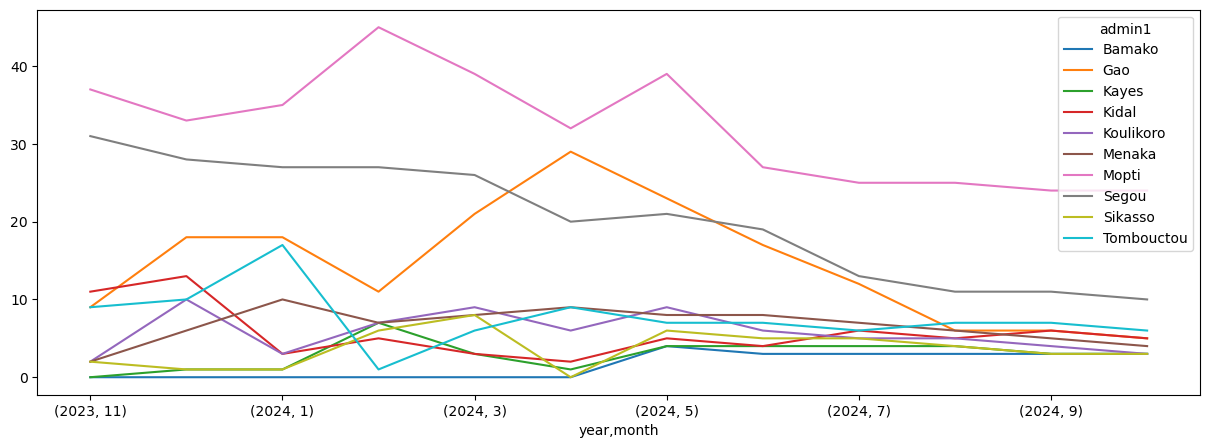

In [43]:
# Pivoter le dataframe pour obtenir les événements par région administrative
next_events_by_admin1 = all_next_months.pivot(index=['year', 'month'], values='nb_events_by_admin', columns='admin1')

next_events_by_admin1 = next_events_by_admin1.fillna(0)
next_events_by_admin1 = np.ceil(next_events_by_admin1).astype(int)
# Afficher les premières lignes du dataframe pivoté
print(next_events_by_admin1)

# Tracer les prédictions des événements par région administrative
next_events_by_admin1.plot(figsize=(15, 5))

# Afficher le graphique
plt.show()


In [30]:

next_events_by_admin1

admin1      Bamako  Gao  Kayes  Kidal  Koulikoro  Menaka  Mopti  Segou  \
year month                                                               
2023 11          0    9      0     11          2       2     37     31   
     12          0   18      1     13         10       6     33     28   
2024 1           0   18      1      3          3      10     35     27   
     2           0   11      7      5          7       7     45     27   
     3           0   21      3      3          9       8     39     26   
     4           0   29      1      2          6       9     32     20   
     5           3   22      3      5          8       8     42     19   
     6           2   17      4      4          6       8     34     18   
     7           2   11      3      3          6       7     34     13   
     8           2    8      2      3          4       7     33     11   
     9           2    5      2      3          3       3     29     10   
     10          2    4      2      2          2       3     29     10   

admin1      Sikasso  Tombouctou  
year month                       
2023 11           2           9  
     12           1          10  
2024 1            1          17  
     2            6           1  
     3            8           6  
     4            0           9  
     5            5           8  
     6            5           7  
     7            5           6  
     8            3           8  
     9            2           5  
     10           2           5